In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
%matplotlib inline

from keras.layers import concatenate, Dense, BatchNormalization, Activation, Lambda
from keras.models import Model
from keras.callbacks import LearningRateScheduler, History
from keras.optimizers import Adam

import tensorflow as tf

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/albert/github/DenseNet/')
import densenet
sys.path.append('/home/albert/github/tensorflow/src/')
import triplet
import evaluation
import data
import dense

### Data Preparation

In [3]:
train_dict, train_files = data.get_data('train')

preprocess False
keypoints ['Neck']
1.14115095139


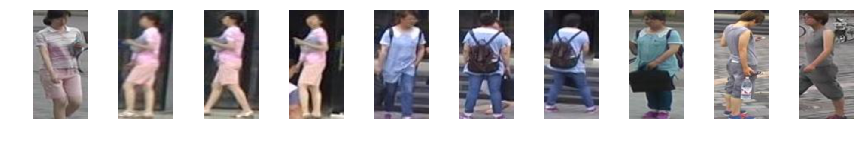

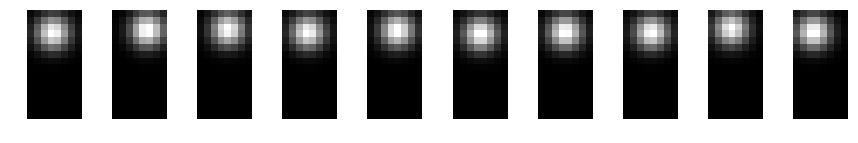

In [4]:
start = time.time()
batch = data.output_batch_generator(train_dict, P=5, K=4, preprocess=False,
                                    shape=(256,128), keypoints=['Neck'], r=0.5).next()
print time.time() - start

plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(batch[0]['input_im'][i].astype(np.uint8))
    plt.axis('off')
plt.show()

import cv2
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(cv2.resize((255 * batch[0]['input_cam'][i]).astype(np.uint8), (8,16)), cmap=plt.cm.gray)
    plt.axis('off')
plt.show()

### Train Network

In [5]:
steps_per_epoch = 100

input_shape = (256,128)

preprocess = True

file_root = 'densenet_triplet_merge_cam'

In [6]:
if os.path.exists('/home/albert/github/tensorflow/models/%s' % file_root) == False:
    os.system('mkdir /home/albert/github/tensorflow/models/%s' % file_root)

In [7]:
# First integer: number of epochs (e.g., 10)
# Second integer: era

epochs = 10

step_decay_cont_str = """
def step_decay_cont(epoch, init_epoch=%d*(%d - 1), init_lr=0.0001):
    drop = 0.5
    epochs_drop = 10.0
    lrate = init_lr * np.power(drop, (epoch + init_epoch)/(epochs_drop))
    return lrate
"""

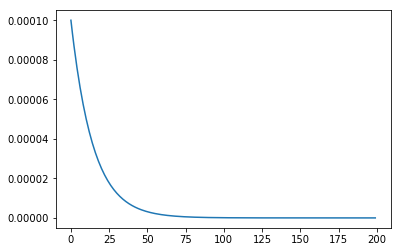

In [8]:
lr = []
for era in range(1,21):
    exec(step_decay_cont_str % (epochs, era))
    for j in range(10):
        lr.append(step_decay_cont(j))
plt.plot(np.arange(200), lr)

In [9]:
P_param = 6
K_param = 4

def_triplet_loss = """

import keras.backend as Keras

def triplet_loss(y_true, y_pred, margin=0.5, P=%d, K=%d, output_dim=%d):
    embeddings = Keras.reshape(y_pred, (-1, output_dim))
    loss = Keras.variable(0, dtype='float32')

    for i in range(P):
        for a in range(K):
            pred_anchor = embeddings[i*K + a]
            hard_pos = Keras.max(triplet.dist(pred_anchor, embeddings[i*K:(i + 1)*K]))
            hard_neg = Keras.min(triplet.dist(pred_anchor, Keras.concatenate([embeddings[0:i*K],
                                                                    embeddings[(i + 1)*K:]], 0)))
            if margin == 'soft':
                loss += triplet.log1p(hard_pos - hard_neg)
            else:
                loss += Keras.maximum(margin + hard_pos - hard_neg, 0.0)
    return loss
""" % (P_param, K_param, 768)

exec(def_triplet_loss)

#### CAM-trained models

In [10]:
input_shape = (256,128)

TF_ROOT = '/home/albert/github/tensorflow/models/branches/'
json_file = '/home/albert/github/tensorflow/models/branches/densenet_triplet/densenet_triplet.json'

base_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet/densenet_triplet_13000.npy')
neck_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_neck_r6_all/densenet_triplet_cam_neck_r6_all_4000.npy')
RHip_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_RHip_r6_all/densenet_triplet_cam_RHip_r6_all_5000.npy')
LHip_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_LHip_r6_all/densenet_triplet_cam_LHip_r6_all_5000.npy')
RShoulder_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_RShoulder_r6_all/densenet_triplet_cam_RShoulder_r6_all_5000.npy')
LShoulder_model = evaluation.load_model(json_file, TF_ROOT + 'densenet_triplet_cam_LShoulder_r6_all/densenet_triplet_cam_LShoulder_r6_all_5000.npy')

In [11]:
base_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im (InputLayer)            (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 128, 64, 64)   9408        input_im[0][0]                   
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 64, 64)   256         conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 128, 64, 64)   0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [12]:
for l in range(len(base_model.layers)):
    if base_model.layers[l].name == 'average_pooling2d_3':
        print l

310


In [13]:
len(base_model.layers)

430

In [14]:
base_model.layers[-120]

In [15]:
for layer in base_model.layers:
    layer.name = layer.name + '_b'
for layer in neck_model.layers:
    layer.name = layer.name + '_n'
for layer in RHip_model.layers:
    layer.name = layer.name + '_RH'
for layer in LHip_model.layers:
    layer.name = layer.name + '_LH'
for layer in RShoulder_model.layers:
    layer.name = layer.name + '_RS'
for layer in LShoulder_model.layers:
    layer.name = layer.name + '_LS'

In [16]:
for layer in base_model.layers[:-120]:
    layer.trainable = False
for layer in neck_model.layers[:-120]:
    layer.trainable = False
for layer in RHip_model.layers[:-120]:
    layer.trainable = False
for layer in LHip_model.layers[:-120]:
    layer.trainable = False
for layer in RShoulder_model.layers[:-120]:
    layer.trainable = False
for layer in LShoulder_model.layers[:-120]:
    layer.trainable = False

In [17]:
# base_model_output_l2 = Lambda(lambda i : tf.nn.l2_normalize(i, 0))(base_model.output)
# neck_model_output_l2 = Lambda(lambda i : tf.nn.l2_normalize(i, 0))(neck_model.output)

In [18]:
# x = concatenate([base_model.output, neck_model.output, RHip_model.output, LHip_model.output, 
#                  RShoulder_model.output, LShoulder_model.output])
# x = Dense(1024)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# predictions = Dense(128, name='final_output')(x)

predictions = concatenate([base_model.output, neck_model.output, RHip_model.output, LHip_model.output, 
                 RShoulder_model.output, LShoulder_model.output], name='final_output')

In [19]:
model = Model(inputs=[base_model.input, neck_model.input, RHip_model.input, 
                      LHip_model.input, RShoulder_model.input, LShoulder_model.input], outputs=predictions)
model.compile(loss=triplet_loss, 
              optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0))

In [20]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_im_b (InputLayer)          (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_im_n (InputLayer)          (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_im_RH (InputLayer)         (None, 256, 128, 3)   0                                            
____________________________________________________________________________________________________
input_im_LH (InputLayer)         (None, 256, 128, 3)   0                                            
___________________________________________________________________________________________

                                                                   conv2d_32_n[0][0]                
____________________________________________________________________________________________________
concatenate_15_RH (Concatenate)  (None, 32, 16, 416)   0           concatenate_14_RH[0][0]          
                                                                   conv2d_32_RH[0][0]               
____________________________________________________________________________________________________
concatenate_15_LH (Concatenate)  (None, 32, 16, 416)   0           concatenate_14_LH[0][0]          
                                                                   conv2d_32_LH[0][0]               
____________________________________________________________________________________________________
concatenate_15_RS (Concatenate)  (None, 32, 16, 416)   0           concatenate_14_RS[0][0]          
                                                                   conv2d_32_RS[0][0]      

____________________________________________________________________________________________________
activation_104_RS (Activation)   (None, 8, 4, 128)     0           batch_normalization_104_RS[0][0] 
____________________________________________________________________________________________________
activation_104_LS (Activation)   (None, 8, 4, 128)     0           batch_normalization_104_LS[0][0] 
____________________________________________________________________________________________________
conv2d_104_b (Conv2D)            (None, 8, 4, 32)      36864       activation_104_b[0][0]           
____________________________________________________________________________________________________
conv2d_104_n (Conv2D)            (None, 8, 4, 32)      36864       activation_104_n[0][0]           
____________________________________________________________________________________________________
conv2d_104_RH (Conv2D)           (None, 8, 4, 32)      36864       activation_104_RH[0][0] 

In [21]:
model.layers[-11].trainable

True

In [22]:
model_json = model.to_json()
with open("/home/albert/github/tensorflow/models/%s/%s.json" % (file_root, file_root), "w") as json_file:
    json_file.write(model_json)

In [23]:
# model.set_weights(np.load('/home/albert/github/tensorflow/models/densenet_triplet_merge_cam_3/densenet_triplet_merge_cam_3_1000.npy'))

In [24]:
train_score = {}
history = History()

for era in range(1,5):
    iterations = era * steps_per_epoch * epochs
    exec(step_decay_cont_str % (epochs, era))
    lrate = LearningRateScheduler(step_decay_cont)
    
    model.fit_generator(data.output_batch_generator(train_dict, model=model, P=P_param, K=K_param, 
                                                    preprocess=True,
                                                    shape=(256,128)), 
                         steps_per_epoch=steps_per_epoch,
                         epochs=epochs,
                         callbacks=[lrate, history])
    
    file_name = file_root + '_' + str(iterations) + '.npy'
    np.save('/home/albert/github/tensorflow/models/%s/%s' % (file_root, file_name), model.get_weights())
    
    train_score[iterations] = evaluation.get_score(model,
                                                   hist=history, preprocess=preprocess, 
                                                   shape=input_shape)
    print 'train' , iterations, train_score[iterations]['rank']

preprocess True
keypoints None
Epoch 1/10
100/100 [==============================] - 185s - loss: 5.8002   
Epoch 2/10
100/100 [==============================] - 178s - loss: 12.3066   
Epoch 3/10
100/100 [==============================] - 179s - loss: 13.3318   
Epoch 4/10
100/100 [==============================] - 177s - loss: 9.8670   
Epoch 5/10
100/100 [==============================] - 179s - loss: 12.4932   
Epoch 6/10
100/100 [==============================] - 177s - loss: 5.7780   
Epoch 7/10
100/100 [==============================] - 177s - loss: 5.3083   
Epoch 8/10
100/100 [==============================] - 178s - loss: 4.2490   
Epoch 9/10
100/100 [==============================] - 179s - loss: 8.7037   
Epoch 10/10
100/100 [==============================] - 177s - loss: 7.4108   
1000 121.32563591
2000 239.405698061
3000 357.344284058
4000 475.225635052
5000 593.147421122
6000 711.0348351
7000 828.915301085
8000 946.826089144
9000 1064.60028791
10000 1182.54578996
11000 1

In [25]:
np.savez('/home/albert/github/tensorflow/models/%s/%s_test_score.npz' % (file_root, file_root), train_score)

### Evaluation